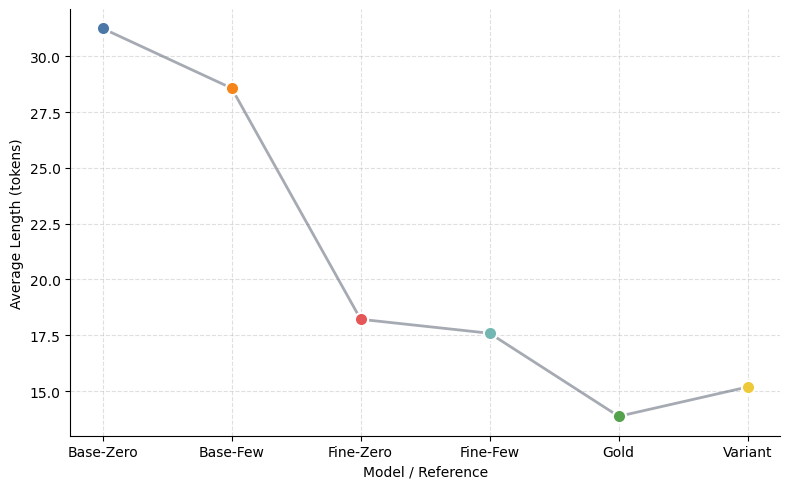

=== Plot Data ===
        Name  Avg_Length
0  Base-Zero   31.246575
1   Base-Few   28.568493
2  Fine-Zero   18.213992
3   Fine-Few   17.586592
4       Gold   13.865753
5    Variant   15.181336
已保存：avg_lengths_summary.csv, avg_lengths_plot.png


In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

files = [
    "base_zero_automatic_scores_separated.csv",
    "base_few_automatic_scores_separated.csv",
    "fine_zero_automatic_scores_separated.csv",
    "fine_few_automatic_scores_separated.csv"
]

name_map = {
    "base_zero_automatic_scores_separated.csv": "Base-Zero",
    "base_few_automatic_scores_separated.csv": "Base-Few",
    "fine_zero_automatic_scores_separated.csv": "Fine-Zero",
    "fine_few_automatic_scores_separated.csv": "Fine-Few",
}

# ==== 按你原先的写法：gold 把多条合并统计词数 ====
def gold_len_all_refs(text):
    # 若不是字符串，按空处理
    if not isinstance(text, str):
        return 0
    # 直接按空格切词，统计长度（多条合在一起也自然算进来）
    return len(text.split())

# ==== 按你原先的写法：variant 去掉第一条，其余求平均 ====
def variant_avg_len_excluding_first(variants):
    if not isinstance(variants, str):
        return 0
    variants_cleaned = variants.replace('•', '').strip()
    # 仅按换行切分（保持你的原逻辑，不额外兼容 '||'）
    variants_list = [v.strip() for v in variants_cleaned.split('\n') if v.strip()]
    variants_excluded_first = variants_list[1:]
    if len(variants_excluded_first) == 0:
        # 和你之前一致：无剩余就记 0（如果想不拉低均值，可换成 np.nan）
        return 0
    lengths = [len(v.split()) for v in variants_excluded_first]
    return sum(lengths) / len(lengths)

def prediction_avg_len(df):
    return df['prediction'].astype(str).str.split().str.len().mean()

# 检查文件
missing = [f for f in files if not os.path.exists(f)]
if missing:
    raise FileNotFoundError(f"缺少文件：{missing}")

# --- 1) 先从第一个文件算 gold/variant（多条参考都算进来） ---
df_first = pd.read_csv(files[0]).copy()
df_first['gold_len_all'] = df_first['gold_reference'].apply(gold_len_all_refs)
df_first['variant_len_avg_excl_first'] = df_first['variant_references'].apply(variant_avg_len_excluding_first)

gold_avg_len = float(df_first['gold_len_all'].mean())
variant_avg_len = float(df_first['variant_len_avg_excl_first'].mean())

# --- 2) 四个文件各自算 prediction 平均长度 ---
rows = []
for file in files:
    df = pd.read_csv(file).copy()
    rows.append({
        "Model": name_map.get(file, file),
        "Prediction_Avg_Len": float(prediction_avg_len(df))
    })

results_df = pd.DataFrame(rows).sort_values("Model").reset_index(drop=True)

# --- 3) 组装绘图数据：四模型 + gold + variant ---
order = ["Base-Zero", "Base-Few", "Fine-Zero", "Fine-Few", "Gold", "Variant"]
plot_df = pd.DataFrame({
    "Name": order,
    "Avg_Length": [
        float(results_df.loc[results_df["Model"]=="Base-Zero", "Prediction_Avg_Len"].values[0]),
        float(results_df.loc[results_df["Model"]=="Base-Few", "Prediction_Avg_Len"].values[0]),
        float(results_df.loc[results_df["Model"]=="Fine-Zero", "Prediction_Avg_Len"].values[0]),
        float(results_df.loc[results_df["Model"]=="Fine-Few", "Prediction_Avg_Len"].values[0]),
        gold_avg_len,
        variant_avg_len,
    ]
})

# --- 4) 导出 CSV（含 gold/variant 两行，便于后续复用） ---
export_df = results_df.copy()
export_df.loc[len(export_df.index)] = {"Model": "Gold", "Prediction_Avg_Len": gold_avg_len}
export_df.loc[len(export_df.index)] = {"Model": "Variant", "Prediction_Avg_Len": variant_avg_len}
export_df.to_csv("avg_lengths_summary.csv", index=False)

# --- 5) 画折线图（matplotlib，单图，不指定颜色/样式） ---
# --- 可视化（无标题 + 更好看的配色） ---
import matplotlib.pyplot as plt

palette = ["#4C78A8","#F58518","#E45756","#72B7B2","#54A24B","#EECA3B"]

x = plot_df["Name"].tolist()
y = plot_df["Avg_Length"].tolist()

plt.figure(figsize=(8, 5))
plt.plot(x, y, linewidth=2, color="#6B7280", alpha=0.6)  # 柔和灰色连线
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.scatter([xi], [yi], s=90, color=palette[i % len(palette)],
                edgecolor="white", linewidth=1.5, zorder=3)

plt.xlabel("Model / Reference")
plt.ylabel("Average Length (tokens)")
plt.grid(True, linestyle="--", alpha=0.4)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("avg_lengths_plot.png", dpi=200)
plt.show()


print("=== Plot Data ===")
print(plot_df)
print("已保存：avg_lengths_summary.csv, avg_lengths_plot.png")